In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math


def binlvl(idx,len_):
  r"""Funciton to calculate and return the binning level for each index.
  """
  return int(math.log(len_+1,2) - math.log(math.gcd(idx+1, len_+1),2)) - 1

def plot_eqbins(ebins, ax_, lw = 1, ls='-', cmin = 0, cmax = -1):
  r"""Function to plot the equibins based on the levels for better understanding.

  NOTE: This function supports plotting of bins only till 6th level i.e. till 64 bins
  """
  colors = ['r','g','b','k','y','c']
  for idx,e in enumerate(ebins):
    if (cmax!= -1) and ((e < cmin) or (e > cmax)):
      continue
    c = colors[binlvl(idx,len(ebins))]
    ax_.axvline(x = e,
                color = c,
                label = 'axvline - full height',
                linewidth = lw,
                linestyle=ls)

def oracle_edh(tr, n_edh):
  bins = tr.shape[-1]

  tr_cs = np.cumsum(tr)
  tr_sum = np.sum(tr)
  edh_bins = np.zeros((n_edh-1))

  for idx in range(edh_bins.shape[-1]):
      edh_bins[idx] = np.argmin(np.abs(tr_cs - tr_sum*(idx+1.0)/n_edh))

  return edh_bins+1

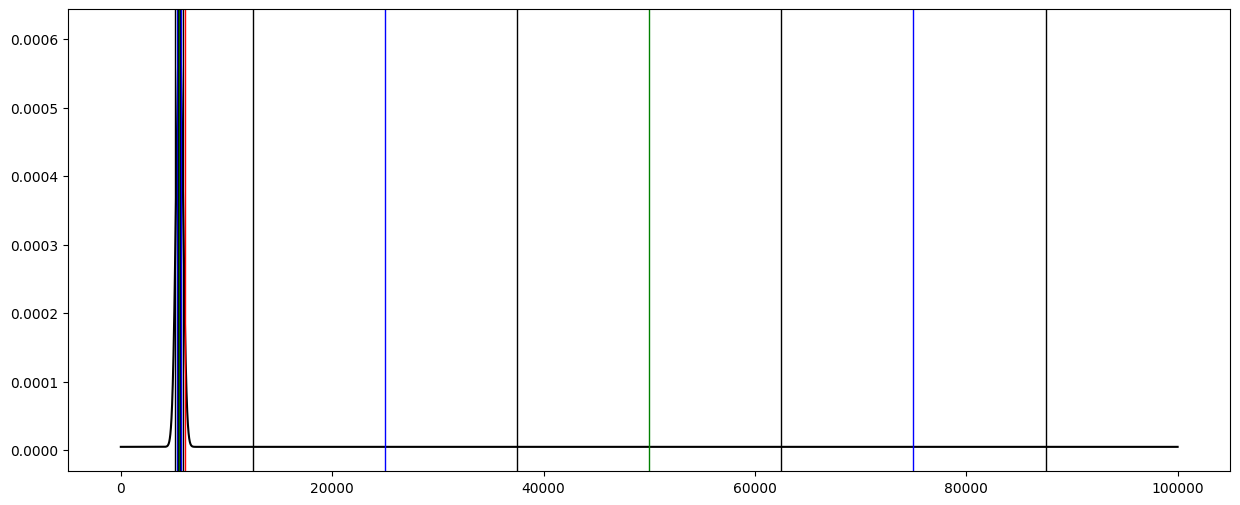

In [9]:
# constants
c = 3e8 # Speed of light in m/s

# Setting the simulation parameters

################################################################################

# d-ToF SPAD Laser properties
T = 100*1e-9 # Laser time period in s
FWHM = 2.317925*1e-9 # Full width half maximum of the laser pulse (Controls the pulse width)
N_tbins = 100000 # Resolution of the laser pulse
N_cycles = 1


# Calculating dependent variables
max_depth = T*c/2.0
bin_size = T*1.0/N_tbins
sigma = FWHM/(2.355*bin_size)

# Number of bins in equi-depth-histogram
N_edh_bins = 16

################################################################################

# Setting scene parameters (extrinsic parameters)

gt_depth = 2.5 # scene distance in meters
alpha_sig = 0.5 # Number of signal photons per laser cycle
alpha_bg = 0.5 # Number of ambient/ background photons per laser cycle accross all bins

# Computing the time of flight for given distance and laser parameters
tof =  2*gt_depth/c


# Simulating the return signal
# generating the ideal transient
pulse = np.zeros(N_tbins)
mu = int(tof/bin_size)
pulse[mu] = 1

x = np.linspace(0,N_tbins-1,N_tbins)
# NOTE: sigma and mu have units (number of bins)

# Generating the time shifted laser pulse
tr = (np.exp(-((x - mu)**2)/(2*sigma**2)))/(sigma*np.sqrt(2*np.pi))
tr = np.divide(tr,np.sum(tr, keepdims=True))

# Scaling the returned laser pulse based on albedo and distance fall off
norm_alpha = 0.5 # Normalized albedo at the scene point

tr = norm_alpha*tr/(gt_depth**2)
tr = np.divide(tr,np.sum(tr, keepdims=True))

# Adding ambient number of photons
tr2 = tr*alpha_sig + alpha_bg/N_tbins


fig, ax = plt.subplots(figsize = (15,6))


ax.plot(tr2*N_cycles, '-k', label = "GT transient")
ax.plot(tr2*0, '-w')
gt_edh_bins = oracle_edh(tr2, N_edh_bins)
plot_eqbins(gt_edh_bins, ax)
plt.show()